In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

Simple logistic regression

In [58]:
data = pd.read_csv('data/ML_DATA_LEV.csv')
data.dropna(inplace= True)

#remove line below to train on samples rather than mutations
data.drop_duplicates(subset=['GENE_MUTATION'], keep='first', inplace=True)
data.GENE_MUTATION.value_counts()

GENE_MUTATION
gyrA_A90V     1
gyrB_K668R    1
gyrA_T164M    1
gyrA_Y379C    1
gyrB_G589V    1
             ..
gyrA_D488A    1
gyrA_P119L    1
gyrA_G477E    1
gyrB_A643D    1
gyrA_D94V     1
Name: count, Length: 163, dtype: int64

In [59]:
data.CLEAN_BINARY_PHENOTYPE.value_counts()

CLEAN_BINARY_PHENOTYPE
S    138
R     25
Name: count, dtype: int64

In [60]:
data

,index,DRUG,MIC,LOG2MIC,BINARY_PHENOTYPE,PHENOTYPE_QUALITY,GENE,POSITION,GENE_MUTATION,CLEAN_BINARY_PHENOTYPE,...,T,SASA,snap2_score,snap2_accuracy,dist_MGB,dist_MGE,dist_drug,temp_factor,depth,deep_ddG
0,0,LEV,2.0,1.00,R,MEDIUM,gyrA,90.0,gyrA_A90V,R,...,False,55.555816,-64.0,82.0,14.254302,5.504266,10.310827,40.439999,1.665078,0.089
1,1,LEV,>8,4.00,R,HIGH,gyrA,94.0,gyrA_D94Y,R,...,False,88.155089,81.0,91.0,18.193078,7.778979,14.095746,46.660000,1.733342,-0.376
2,2,LEV,>8,4.00,R,HIGH,gyrA,94.0,gyrA_D94N,R,...,False,88.155089,56.0,75.0,18.193078,7.778979,14.095746,46.660000,1.733342,-0.347
3,3,LEV,2.0,1.00,R,MEDIUM,gyrB,499.0,gyrB_N499D,R,...,False,40.444768,53.0,75.0,21.565351,18.549803,13.333886,62.860001,2.030527,-0.309
4,4,LEV,0.5,-1.00,S,HIGH,gyrA,193.0,gyrA_N193S,S,...,False,3.978588,-22.0,61.0,38.286533,31.644022,37.267766,50.119999,3.114263,-1.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,1623,LEV,0.25,-2.00,S,HIGH,gyrB,601.0,gyrB_I601T,S,...,False,25.392934,-40.0,66.0,27.224609,38.799515,38.672577,96.040001,1.915598,-1.102
1628,1628,LEV,0.5,-1.00,S,HIGH,gyrA,480.0,gyrA_R480C,S,...,False,108.315927,-17.0,57.0,43.646112,41.821476,47.286371,59.320000,1.914005,-0.669
1656,1656,LEV,0.5,-1.00,S,HIGH,gyrA,252.0,gyrA_R252G,S,...,False,117.789422,25.0,63.0,39.778686,31.598502,35.352796,61.540001,1.769443,-1.407
1706,1706,LEV,<=0.12,-3.06,S,HIGH,gyrB,452.0,gyrB_K452N,S,...,False,129.497644,-54.0,78.0,29.899138,38.862500,33.061004,91.370003,1.615220,-0.314


In [61]:
true_label = data.CLEAN_BINARY_PHENOTYPE

features = ['d_volume', 'd_hydropathy_KD', 'd_hydropathy_WW',
       'd_MW', 'd_Pi', 'secondary_structure', 'phi', 'psi', 'residue_sasa', 
       'n_hbond_acceptors', 'n_hbond_donors', 'SASA', 'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_drug', 'temp_factor', 'depth', 'deep_ddG'] # 'B', 'C', 'E', 'G', 'H', 'T',

features = data[features]
features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
features.drop('secondary_structure', inplace = True, axis = 1)

true_label
features

/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_9295/2563246430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_9295/2563246430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop('secondary_structure', inplace = True, axis = 1)


,d_volume,d_hydropathy_KD,d_hydropathy_WW,d_MW,d_Pi,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,dist_MGB,dist_MGE,dist_drug,temp_factor,depth,deep_ddG,secondary_structure_codes
0,51.4,2.4,-0.86,28.0,-0.04,-61.83,-59.76,47.0,2.0,0.0,55.555816,-64.0,14.254302,5.504266,10.310827,40.439999,1.665078,0.089,0
1,82.5,2.2,-2.18,48.1,2.89,-58.04,-41.61,97.4,1.0,1.0,88.155089,81.0,18.193078,7.778979,14.095746,46.660000,1.733342,-0.376,0
2,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56.0,18.193078,7.778979,14.095746,46.660000,1.733342,-0.347,0
3,-3.0,0.0,1.98,1.0,-2.64,-66.66,120.50,43.0,2.0,2.0,40.444768,53.0,21.565351,18.549803,13.333886,62.860001,2.030527,-0.309,1
4,-25.1,2.7,-0.10,-27.0,0.27,-78.75,123.63,5.4,2.0,0.0,3.978588,-22.0,38.286533,31.644022,37.267766,50.119999,3.114263,-1.229,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,-50.6,-5.2,0.92,-12.1,-0.42,-130.11,149.27,24.8,0.0,0.0,25.392934,-40.0,27.224609,38.799515,38.672577,96.040001,1.915598,-1.102,5
1628,-64.9,7.0,-0.78,-53.0,-5.69,-58.30,-53.31,99.4,1.0,1.0,108.315927,-17.0,43.646112,41.821476,47.286371,59.320000,1.914005,-0.669,0
1656,-113.3,4.1,0.14,-99.1,-4.79,-79.33,120.91,123.9,1.0,0.0,117.789422,25.0,39.778686,31.598502,35.352796,61.540001,1.769443,-1.407,3
1706,-54.5,0.4,-1.38,-14.1,-4.33,-96.55,-13.55,131.0,0.0,1.0,129.497644,-54.0,29.899138,38.862500,33.061004,91.370003,1.615220,-0.314,4


In [62]:
random_seed = 144

X_train,X_test,y_train,y_test=train_test_split(features, true_label, test_size=0.30, random_state = random_seed) 

In [63]:
len(X_test)

49

In [64]:
random_seed = 144

folds = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)

param_grid = [ 
                {   'penalty': ['l2'],
                    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'class_weight' : ['balanced', None]
                } 
            ]


In [65]:
gsvc = GridSearchCV(LogisticRegression(random_state=random_seed), param_grid, cv = folds, scoring = ['recall', 'roc_auc', 'precision'], refit = 'recall') #, scoring='f1' , scoring = 'recall'
gsvc.fit(X_train,y_train)
gsvc.cv_results_

/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 21

{'mean_fit_time': array([0.01694083, 0.0142169 , 0.00422869, 0.00697708, 0.00603256,
        0.00457864, 0.01454978, 0.00962996, 0.00231328, 0.00377655,
        0.00411367, 0.00435462, 0.01546683, 0.01228366, 0.0025404 ,
        0.00387554, 0.00477147, 0.0045712 , 0.0171834 , 0.01214185,
        0.00229955, 0.00344272, 0.00422235, 0.00604682, 0.02176886,
        0.01364932, 0.0033886 , 0.00420928, 0.00442133, 0.00449467,
        0.02566128, 0.01446233, 0.00258775, 0.00418215, 0.00408888,
        0.00418596, 0.03283176, 0.01177306, 0.00348172, 0.00414705,
        0.00455575, 0.00526705, 0.03392153, 0.01177845, 0.00341434,
        0.00971985, 0.00405741, 0.00484977, 0.04712453, 0.01210208,
        0.00329108, 0.00430784, 0.00428991, 0.00518456, 0.05060158,
        0.01155581, 0.00335336, 0.00757418, 0.00417361, 0.00426927,
        0.06110044, 0.01264606, 0.00388093, 0.00505643, 0.00459104,
        0.00458817, 0.07050076, 0.01173873, 0.00368576, 0.00451498,
        0.00424275, 0.00420046,

In [66]:
#gsvc = 

In [67]:
df = pd.DataFrame(gsvc.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_class_weight', 'param_penalty', 'param_solver',
       'params', 'split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall', 'split4_test_recall',
       'mean_test_recall', 'std_test_recall', 'rank_test_recall',
       'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc',
       'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc',
       'std_test_roc_auc', 'rank_test_roc_auc', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision'],
      dtype='object')

In [68]:
gsvc.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [69]:
gsvc.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [70]:
logreg =  LogisticRegression(solver='newton-cg', random_state=random_seed, class_weight = 'balanced', C = 0.001, penalty = 'l2') 

In [71]:
logreg.fit(X_train,y_train) 

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [72]:
y_pred=logreg.predict(X_test) 

In [73]:
y_df = pd.DataFrame(y_pred)
y_df.value_counts()

S    38
R    11
Name: count, dtype: int64

In [74]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix 

array([[ 3,  2],
       [ 8, 36]])

Text(0.5, 427.9555555555555, 'Predicted label')

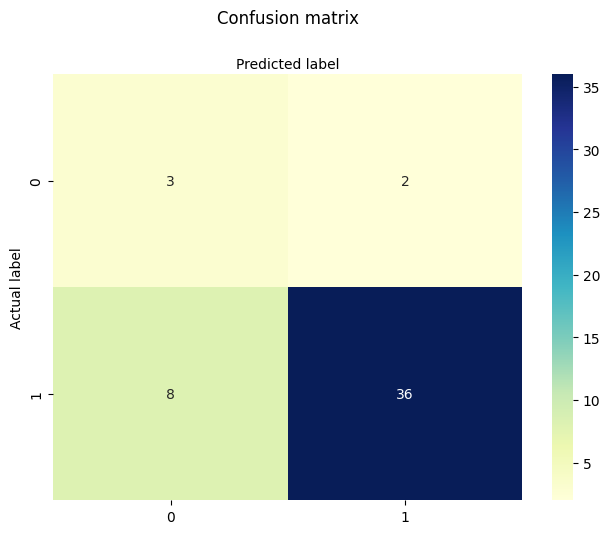

In [75]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [76]:
sensitivity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
specificity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print(sensitivity, specificity)

0.8181818181818182 0.6
